In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torchvision import transforms
import torch.optim as optim
import numpy as np
import gym
import os
import pandas as pd
import warnings

from models import MDRNNCell, VAE, Controller, MDRNN
from train_mdn import *

warnings.simplefilter("ignore")

In [2]:
device = "cuda"
time_limit = 1000
discrete = 0

# Load models
rollout = RolloutGenerator(device, time_limit, discrete)

In [3]:
cumulative, rollout_current_hidden, rollout_next_hidden, rollout_latents, rollout_actions, rollout_rewards, rollout_dones = rollout.do_rollout()

In [4]:
print("Cumulative reward: ", cumulative)
print("Rollout current hidden: ", rollout_current_hidden.shape)
print("Rollout next hidden: ", rollout_next_hidden.shape)
print("Rollout latents: ", rollout_latents.shape)
print("Rollout actions: ", rollout_actions.shape)
print("Rollout rewards: ", rollout_rewards.shape)
print("Rollout dones: ", rollout_dones.shape)

Cumulative reward:  392.26241134751604
Rollout current hidden:  (510, 1, 256)
Rollout next hidden:  (510, 1, 256)
Rollout latents:  (511, 32)
Rollout actions:  (510, 3)
Rollout rewards:  (510,)
Rollout dones:  (510,)


In [9]:
dir_path = './results/'
files = os.listdir(dir_path)
files = [f for f in files if 'best_1_1_G' in f]

num = -1
idx = 0
file = ''
for idx, fi in enumerate(files):
    Gnum = fi.split('G')[1].split('.')[0]
    Gnum = int(Gnum)
    if Gnum > num:
        file = fi
        num = Gnum
        
file_path = dir_path + file
file_path

'./results/best_1_1_G399.p'

In [10]:
ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE = 3, 32, 256, 64, 64

s = torch.load(file_path) # ファイルから個体をロード
mdrnn = MDRNNCell(LSIZE, ASIZE, RSIZE, 5).to(device)
mdrnn.load_state_dict(s['mdrnn'])
mdrnn

MDRNNCell(
  (gmm_linear): Linear(in_features=256, out_features=327, bias=True)
  (rnn): LSTMCell(35, 256)
)

In [7]:
def gmm_loss(batch, mus, sigmas, logpi, reduce=True):
    """1step MDN-RNNの損失関数

    params:
        batch: (B, *) バッチ
        mus: (B, K, A) 平均
        sigmas: (B, K, A) 分散
        logpi: (B, K) log(pi)
        reduce: bool, default True
    """
    batch = batch.unsqueeze(-2)
    sigmas = torch.abs(sigmas)
    normal_dist = Normal(mus, sigmas)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)
    if reduce:
        return - torch.mean(log_prob)
    return - log_prob

In [7]:
# rnnレイヤーの重みを固定
for param in mdrnn.rnn.parameters():
    param.requires_grad = False

mdn = mdrnn.gmm_linear
mdn_input = rollout_next_hidden.reshape(-1, RSIZE)
mdn_input = torch.tensor(mdn_input, dtype=torch.float32, device=device)
mdn_out = mdn(mdn_input)
mus = mdn_out[:, :5 * LSIZE].reshape(-1, 5, LSIZE)
sigmas = mdn_out[:, 5 * LSIZE: 2*5*LSIZE].reshape(-1, 5, LSIZE)
pi = mdn_out[:, 2*5*LSIZE:2*5*LSIZE+5].reshape(-1, 5)
logpi = F.log_softmax(pi, dim=-2)
reward = mdn_out[:, -2]
done = mdn_out[:, -1]

print("True State: ", rollout_latents[1:].shape)
print("True Reward: ", rollout_rewards.shape)
print("Mus: ", mus.shape)
print("Sigmas: ", sigmas.shape)
print("Logpi: ", logpi.shape)
print("Reward: ", reward.shape)
print("Done: ", done.shape)

True State:  (510, 32)
True Reward:  (510,)
Mus:  torch.Size([510, 5, 32])
Sigmas:  torch.Size([510, 5, 32])
Logpi:  torch.Size([510, 5])
Reward:  torch.Size([510])
Done:  torch.Size([510])


In [9]:
rollout_latents = torch.tensor(rollout_latents, dtype=torch.float32, device=device)

loss = gmm_loss(rollout_latents[1:], mus[:-1], sigmas[:-1], logpi[:-1], reduce=True)

In [10]:
loss

tensor(2808.7278, device='cuda:0', grad_fn=<NegBackward0>)

In [18]:
def reward_loss(batch, rewards, reduce=True):
    """rewardの対数オッズ

    params:
        batch: (B, *) バッチ
        reward: (B, *) reward
        reduce: bool, default True
    """
    loss = nn.BCEWithLogitsLoss(reduction='none')
    reward_loss = loss(batch, rewards)

    if reduce:
        return - torch.mean(reward_loss)
    return - reward_loss

In [12]:
rollout_rewards = torch.tensor(rollout_rewards, dtype=torch.float32, device=device).view(-1, 1)
rollout_rewards.cpu()
reward = reward.view(-1, 1)
reward.cpu()

print("Rollout Rewards: ", rollout_rewards.shape)
print("Reward: ", reward.shape)

Rollout Rewards:  torch.Size([1002, 1])
Reward:  torch.Size([1002, 1])


In [19]:
loss = reward_loss(rollout_rewards, reward, reduce=True)

In [20]:
loss

tensor(-0.8885, device='cuda:0', grad_fn=<NegBackward0>)

In [2]:
dir_path = './results/'
files = os.listdir(dir_path)
files = [f for f in files if 'best_1_1_G' in f]

num = -1
idx = 0
file = ''
for idx, fi in enumerate(files):
    Gnum = fi.split('G')[1].split('.')[0]
    Gnum = int(Gnum)
    if Gnum > num:
        file = fi
        num = Gnum
        
file_path = dir_path + file
file_path

'./results/best_1_1_G399.p'

In [3]:
import os

dir_path = './results/'
files = os.listdir(dir_path)
files = [f for f in files if 'mdn_' in f]

num = -1
idx = 0
checkpoint_file = ''
for idx, fi in enumerate(files):
    Gnum = fi.split('_')[1].split('.')[0]
    Gnum = int(Gnum)
    if Gnum > num:
        checkpoint_file = fi
        num = Gnum
        
checkpoint_path = dir_path + checkpoint_file
checkpoint_path

'./results/mdn_9430.p'

In [4]:
def gmm_loss(batch, mus, sigmas, logpi, reduce=True):
    """1step MDN-RNNの損失関数

    params:
        batch: (B, *) バッチ
        mus: (B, K, A) 平均
        sigmas: (B, K, A) 分散
        logpi: (B, K) log(pi)
        reduce: bool, default True
    """
    batch = batch.unsqueeze(-2)
    normal_dist = Normal(mus, torch.abs(sigmas)+1e-8)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)
    if reduce:
        return - torch.mean(log_prob)
    return - log_prob

In [5]:
def convert_binary(batch):
    """バイナリに変換

    params:
        batch: (B, *) バッチ
    """
    binary_batch = torch.where(batch > 0, torch.tensor(1.0), torch.tensor(0.0))

    return binary_batch

def reward_loss(batch, rewards, reduce=True):
    """rewardの対数オッズ

    params:
        batch: (B, *) バッチ
        reward: (B, *) reward
        reduce: bool, default True
    """
    loss = nn.BCEWithLogitsLoss(reduction='none')
    binary_batch = convert_binary(batch)
    sigmoid_reward = torch.sigmoid(rewards)
    reward_loss = loss(binary_batch, sigmoid_reward)

    if reduce:
        return torch.mean(reward_loss)
    return reward_loss

In [6]:
epoch = 5000
device = "cuda"
time_limit = 1000
discrete = 0
epoch_num = 1
checkpoint_flag = False
ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE = 3, 32, 256, 64, 64

s = torch.load(file_path)
mdrnn = MDRNNCell(LSIZE, ASIZE, RSIZE, 5).to(device)
mdrnn.load_state_dict(s['mdrnn'])

for param in mdrnn.rnn.parameters():
    param.requires_grad = False

mdn = mdrnn.gmm_linear

losses = []
losses_mdn = []
losses_reward = []
rollout = RolloutGenerator(device, time_limit, discrete)

optimizer = optim.Adam(mdn.parameters(), lr=1e-4)

if checkpoint_file != '':
    o = torch.load(checkpoint_path)
    mdn.load_state_dict(o['mdn'])
    optimizer.load_state_dict(o['optimizer'])
    epoch_num = o['epoch']
    checkpoint_flag = True


for i in range(epoch):
    cumulative, rollout_current_hidden, rollout_next_hidden, rollout_latents, rollout_actions, rollout_rewards, rollout_dones = rollout.do_rollout()
    rollout_latents = rollout_latents[1:]

    optimizer.zero_grad()

    mdn_input = rollout_next_hidden.reshape(-1, RSIZE)
    mdn_input = torch.tensor(mdn_input, dtype=torch.float32, device=device)
    mdn_out = mdn(mdn_input)
    mus = mdn_out[:, :5 * LSIZE].reshape(-1, 5, LSIZE)
    sigmas = mdn_out[:, 5 * LSIZE: 2*5*LSIZE].reshape(-1, 5, LSIZE)
    pi = mdn_out[:, 2*5*LSIZE:2*5*LSIZE+5].reshape(-1, 5)
    logpi = F.log_softmax(pi, dim=-2)
    reward = mdn_out[:, -2]
    done = mdn_out[:, -1]

    rollout_latents = torch.tensor(rollout_latents, dtype=torch.float32, device=device)
    g_loss = gmm_loss(rollout_latents, mus, sigmas, logpi, reduce=True)

    rollout_rewards = torch.tensor(rollout_rewards, dtype=torch.float32, device=device).view(-1, 1)
    reward = reward.view(-1, 1)
    # print(rollout_rewards.shape)
    # print(reward.shape)
    r_loss = reward_loss(rollout_rewards, reward, reduce=True)

    loss = g_loss + r_loss

    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    losses_mdn.append(g_loss.item())
    losses_reward.append(r_loss.item())

    if i % 10 == 0:
        if checkpoint_flag:
            print("Epoch: {}, Loss: {}, GMM Loss: {}, Reward Loss: {}".format(i+epoch_num+1, loss.item(), g_loss.item(), r_loss.item()))
            checkpoint = {
                'mdn': mdn.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': i+epoch_num+1
            }
            torch.save(checkpoint, './results/mdn_{}.p'.format(i+epoch_num+1))
        else:
            print("Epoch: {}, Loss: {}, GMM Loss: {}, Reward Loss: {}".format(i, loss.item(), g_loss.item(), r_loss.item()))
            checkpoint = {
                'mdn': mdn.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': i
            }
            torch.save(checkpoint, './results/mdn_{}.p'.format(i))

if checkpoint_flag:
    print("Epoch: {}, Loss: {}, GMM Loss: {}, Reward Loss: {}".format(i+epoch_num+1, loss.item(), g_loss.item(), r_loss.item()))
    checkpoint = {
        'mdn': mdn.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': i+epoch_num+1
    }
    torch.save(checkpoint, './results/mdn_{}.p'.format(i+epoch_num+1))
else:
    print("Epoch: {}, Loss: {}, GMM Loss: {}, Reward Loss: {}".format(i, loss.item(), g_loss.item(), r_loss.item()))
    checkpoint = {
        'mdn': mdn.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': i
    }
    torch.save(checkpoint, './results/mdn_{}.p'.format(i))


print("Finish")

loss = pd.DataFrame(losses)
loss_mdn = pd.DataFrame(losses_mdn)
loss_reward = pd.DataFrame(losses_reward)

if checkpoint_flag:
    loss_old = pd.read_csv('./results/loss.csv')
    loss_mdn_old = pd.read_csv('./results/loss_mdn.csv')
    loss_reward_old = pd.read_csv('./results/loss_reward.csv')
    loss = pd.concat([loss_old, loss])
    loss_mdn = pd.concat([loss_mdn_old, loss_mdn])
    loss_reward = pd.concat([loss_reward_old, loss_reward])
    loss.to_csv('./results/loss.csv')
    loss_mdn.to_csv('./results/loss_mdn.csv')
    loss_reward.to_csv('./results/loss_reward.csv')
else:
    loss.to_csv('./results/loss.csv')
    loss_mdn.to_csv('./results/loss_mdn.csv')
    loss_reward.to_csv('./results/loss_reward.csv')

Epoch: 9431, Loss: 59.3471794128418, GMM Loss: 58.747623443603516, Reward Loss: 0.5995545983314514
Epoch: 9441, Loss: 61.8845100402832, GMM Loss: 61.289405822753906, Reward Loss: 0.5951043963432312
Epoch: 9451, Loss: 58.01165008544922, GMM Loss: 57.395286560058594, Reward Loss: 0.6163634061813354
Epoch: 9461, Loss: 60.233646392822266, GMM Loss: 59.636295318603516, Reward Loss: 0.597352147102356
Epoch: 9471, Loss: 63.55897521972656, GMM Loss: 62.95621871948242, Reward Loss: 0.6027552485466003
Epoch: 9481, Loss: 62.41719436645508, GMM Loss: 61.806419372558594, Reward Loss: 0.6107752919197083
Epoch: 9491, Loss: 60.11621856689453, GMM Loss: 59.52388381958008, Reward Loss: 0.5923357009887695
Epoch: 9501, Loss: 62.16176986694336, GMM Loss: 61.56597900390625, Reward Loss: 0.5957911014556885
Epoch: 9511, Loss: 61.44721221923828, GMM Loss: 60.83351516723633, Reward Loss: 0.6136972308158875
Epoch: 9521, Loss: 61.95087432861328, GMM Loss: 61.355079650878906, Reward Loss: 0.5957949161529541
Epoch:

KeyboardInterrupt: 

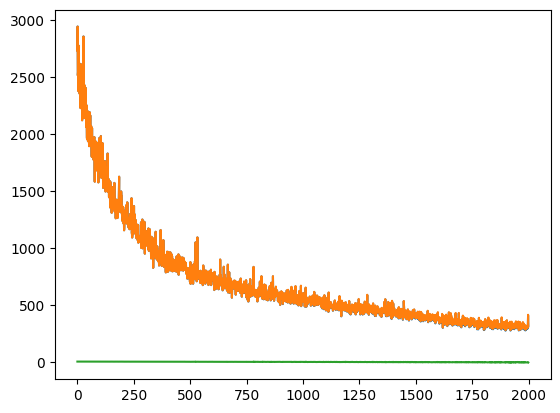

In [12]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.plot(losses_mdn)
plt.plot(losses_reward)